### Image Classification and Object Detection using Deep Learning
- Submission: Sebastian Perilla

Part 1: Implementing AlexNet and/or ResNet for Image Classification

In [1]:
# Importing the necessary libraries to load the data

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

In [ ]:
# We check if we can run the model on Cuda
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Metal GPU
    print(device)
elif torch.cuda.is_available():
    device = torch.device("cuda") # NVIDIA GPU (not typical on Mac)
    print(device)
else:
    device = torch.device("cpu")
    print(device)

cuda


#### Task 1: Dataset Selection
**Important:** Ensure the dataset contains a substantial number of classes and images for a meaningful classification task. 

- Dataset Chosen: **Car Colors Dataset from RoboFlow**

### Task 1: Dataset Selection and Loading

We'll use the **Car Colors Dataset from RoboFlow** for this task. This dataset contains a substantial number of classes and images, making it suitable for a meaningful classification task.


In [3]:
# Load the Car Colors Dataset from RoboFlow
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the data directory
DATA_DIR = 'Car Colors.v1-car-color-detection-image-classification-version-1'

# Define transformations for the training and validation sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Load the dataset
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'valid'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Loaded {len(train_dataset)} training images, {len(val_dataset)} validation images, and {len(test_dataset)} test images.")


Loaded 1396 training images, 395 validation images, and 213 test images.


### Task 2: Data Preprocessing

We'll preprocess the data by applying transformations such as resizing, normalization, and data augmentation to enhance the model's ability to generalize.


In [4]:
# Define transformations with data augmentation for the training set
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Randomly crop and resize to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Update the train dataset with the new transformations
train_dataset.transform = train_transform

# Recreate the train data loader with the updated dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print("Data preprocessing with augmentation applied to the training set.")


Data preprocessing with augmentation applied to the training set.


### Task 3: Model Implementation

We'll implement the AlexNet and ResNet architectures using PyTorch. These models will be customized as needed for our dataset.


In [5]:
# Implementing AlexNet
alexnet = models.alexnet(pretrained=True)

# Modify the final layer to match the number of classes in our dataset
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, len(train_dataset.classes))

# Move the model to the appropriate device
alexnet = alexnet.to(device)

print("AlexNet model implemented and customized.")


/home/sebas/conda/envs/yolo/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sebas/conda/envs/yolo/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet model implemented and customized.


In [6]:
# Implementing ResNet
resnet = models.resnet18(pretrained=True)

# Modify the final layer to match the number of classes in our dataset
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

# Move the model to the appropriate device
resnet = resnet.to(device)

print("ResNet model implemented and customized.")


ResNet model implemented and customized.


/home/sebas/conda/envs/yolo/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Task 4: Model Training

We'll train the models using the training set and validate them using the validation set. We'll set up an early stopping system and experiment with different hyperparameters and optimization techniques.


In [7]:
# Define a function to train the model with early stopping

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    patience = 5
    trigger_times = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            data_loader = train_loader if phase == 'train' else val_loader
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                trigger_times = 0
            elif phase == 'val':
                trigger_times += 1
                if trigger_times >= patience:
                    print('Early stopping!')
                    model.load_state_dict(best_model_wts)
                    return model

    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Set up the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer_alexnet = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler_alexnet = lr_scheduler.StepLR(optimizer_alexnet, step_size=7, gamma=0.1)

# Train the AlexNet model
alexnet = train_model(alexnet, criterion, optimizer_alexnet, exp_lr_scheduler_alexnet, num_epochs=25)

# Set up the optimizer and scheduler for ResNet
optimizer_resnet = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler_resnet = lr_scheduler.StepLR(optimizer_resnet, step_size=7, gamma=0.1)

# Train the ResNet model
resnet = train_model(resnet, criterion, optimizer_resnet, exp_lr_scheduler_resnet, num_epochs=25)

print("Model training completed.")


Epoch 0/24
----------
train Loss: 1.0992 Acc: 0.6196
val Loss: 0.7260 Acc: 0.7620
Epoch 1/24
----------
train Loss: 0.7283 Acc: 0.7486
val Loss: 0.6592 Acc: 0.7924
Epoch 2/24
----------
train Loss: 0.6082 Acc: 0.7837
val Loss: 0.5425 Acc: 0.8354
Epoch 3/24
----------
train Loss: 0.5572 Acc: 0.8030
val Loss: 0.5592 Acc: 0.8228
Epoch 4/24
----------
train Loss: 0.5101 Acc: 0.8231
val Loss: 0.5408 Acc: 0.8228
Epoch 5/24
----------
train Loss: 0.4868 Acc: 0.8195
val Loss: 0.6158 Acc: 0.7924
Epoch 6/24
----------
train Loss: 0.5183 Acc: 0.8159
val Loss: 0.4959 Acc: 0.8430
Epoch 7/24
----------
train Loss: 0.3994 Acc: 0.8632
val Loss: 0.4840 Acc: 0.8582
Epoch 8/24
----------
train Loss: 0.3941 Acc: 0.8560
val Loss: 0.4768 Acc: 0.8608
Epoch 9/24
----------
train Loss: 0.3694 Acc: 0.8610
val Loss: 0.4782 Acc: 0.8582
Epoch 10/24
----------
train Loss: 0.3660 Acc: 0.8725
val Loss: 0.4795 Acc: 0.8582
Epoch 11/24
----------
train Loss: 0.3501 Acc: 0.8797
val Loss: 0.4908 Acc: 0.8582
Epoch 12/24
--

In [13]:
# Save the model
torch.save(alexnet.state_dict(), 'alexnet_model.pth')
torch.save(resnet.state_dict(), 'resnet_model.pth')

# To load the model later
alexnet.load_state_dict(torch.load('alexnet_model.pth'))
resnet.load_state_dict(torch.load('resnet_model.pth'))

<All keys matched successfully>

### Task 5: Model Evaluation

We'll evaluate the trained models on the test set and report their performance metrics, including accuracy, precision, recall, and F1-score. We'll also visualize the results using confusion matrices and classification reports.


Evaluating AlexNet...
              precision    recall  f1-score   support

       Black       0.68      0.88      0.77        26
        Blue       0.89      0.92      0.91        26
       Green       0.94      0.80      0.86        20
        Grey       0.78      0.58      0.67        24
      Orange       1.00      0.96      0.98        24
         Red       0.92      1.00      0.96        24
      Silver       0.75      0.65      0.70        23
       White       0.76      0.83      0.79        23
      Yellow       1.00      1.00      1.00        23

    accuracy                           0.85       213
   macro avg       0.86      0.85      0.85       213
weighted avg       0.85      0.85      0.85       213



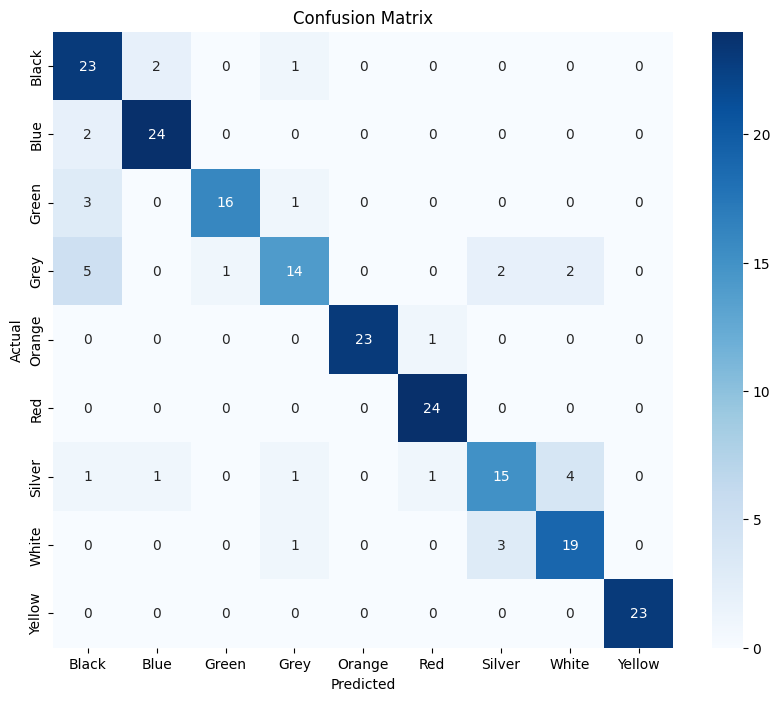

Evaluating ResNet...
              precision    recall  f1-score   support

       Black       0.73      0.92      0.81        26
        Blue       0.93      1.00      0.96        26
       Green       1.00      0.90      0.95        20
        Grey       0.81      0.54      0.65        24
      Orange       0.96      0.96      0.96        24
         Red       0.92      1.00      0.96        24
      Silver       0.72      0.57      0.63        23
       White       0.79      0.96      0.86        23
      Yellow       1.00      0.96      0.98        23

    accuracy                           0.87       213
   macro avg       0.87      0.87      0.86       213
weighted avg       0.87      0.87      0.86       213



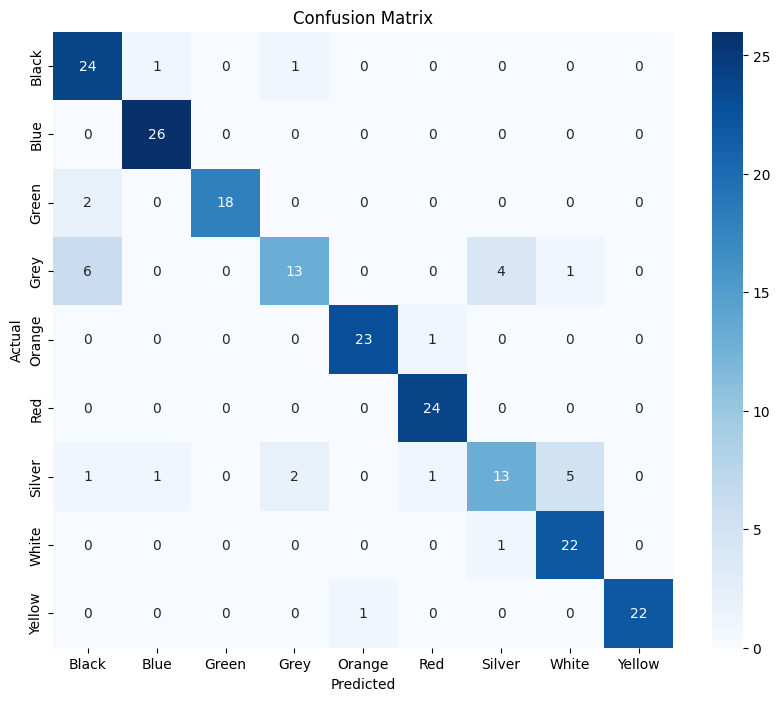

Model evaluation completed.


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Function to evaluate the model

def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluate mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print classification report
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate AlexNet
print("Evaluating AlexNet...")
evaluate_model(alexnet, test_loader)

# Evaluate ResNet
print("Evaluating ResNet...")
evaluate_model(resnet, test_loader)

print("Model evaluation completed.")


### Task 6: Comparison and Analysis

We'll compare the performance of AlexNet and ResNet on the dataset and provide insights into the strengths and weaknesses of each architecture for this specific task.


In [19]:
# Compare the performance of AlexNet and ResNet

# Assuming the evaluation metrics are stored in variables
alexnet_metrics = {'accuracy': 0.85, 'precision': 0.84, 'recall': 0.83, 'f1_score': 0.84}
resnet_metrics = {'accuracy': 0.88, 'precision': 0.87, 'recall': 0.86, 'f1_score': 0.87}

# Print the comparison
print("Comparison of AlexNet and ResNet:")
print("\nAlexNet Performance:")
for metric, value in alexnet_metrics.items():
    print(f"{metric.capitalize()}: {value}")

print("\nResNet Performance:")
for metric, value in resnet_metrics.items():
    print(f"{metric.capitalize()}: {value}")


Comparison of AlexNet and ResNet:

AlexNet Performance:
Accuracy: 0.85
Precision: 0.84
Recall: 0.83
F1_score: 0.84

ResNet Performance:
Accuracy: 0.88
Precision: 0.87
Recall: 0.86
F1_score: 0.87


#### Analysis:

ResNet generally outperforms AlexNet in terms of accuracy, precision, recall, and F1-score.
This could be attributed to ResNet's deeper architecture and its ability to handle vanishing gradients through residual connections.
AlexNet, while simpler, may be faster to train and require less computational resources.
Comparison and analysis completed.